# Detecció d'opinions amb un model unsupervised

In [1]:
# Math
from math import log, exp, sqrt, tanh, cosh, sinh, log10

# NLTK
import nltk

from nltk.corpus import movie_reviews as mr
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('movie_reviews')

# Sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, train_test_split

#Typing
from typing import Tuple

# Pandas
import pandas as pd

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import dill as pickle

[nltk_data] Downloading package wordnet to /home/barre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/barre/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/barre/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


## Obtención de los datos y separación train-test

In [2]:
y = ["pos"]*1000 + ["neg"]*1000 
corpus = []
for rev in mr.fileids():
    corpus.append((mr.raw(rev)))

X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=42)

## Definición de nuestro modelo no supervisado

In [2]:
def movie_review_categorizer(review: str,func = lambda x: x, mode = 3, max_sum = False, theta = 1) -> str:
    
   """Función que recibe una review como parámetro y preprocesa dicha review,
    eliminando los caracteres especiales y convirtiéndolas a minúsculas.
    Luego, se separa dicha review por oraciones, escogiendo el synset correspondiente para cada palabra
    dentro de la oración mediante desambiguación de Lesk. 
    Finalmente se realiza el análisis de sentimiento de cada synset y se devuelve la media de el resultado de aplicar
    la función func a cada puntuación de cada palabra. En caso de haber mayoría para neg se devuelve neg, 
    y en caso contrario o en caso de empate se devolverá pos
    
    Parámetros:
    - review: String conteniendo la reseña de la película.
    - func: Función de Python representando la función a aplicar a las puntuaciones de los synsets. Por defecto, es la función identidad.
    - mode: El número de partes del discurso a considerar para lesk. Por defecto, se consideran todas (3).
    - max_sum: Booleano que indica si se debe considerar la suma máxima de las puntuaciones de los synsets. Por defecto, es False.
    - theta: Parámetro de ajuste para las puntuaciones de las palabras. Por defecto, es 1.
    
    Devuelve:
    - String cuyo valor es 'pos' si el sentimiento es positivo, 'neg' si es negativo. En caso de empate, devuelve 'pos'.
    """
   
   modes =["a","n","r","v"]
   modes = modes[0:mode]

   # preprocessing
   rev_score = {'pos': 0, 'neg': 0} 
   review = ''.join(c for c in review if c.isalpha() or c == ' ')
   review = review.lower()
   stop_words = set(stopwords.words('english'))
   review = ' '.join([word for word in review.split() if word not in stop_words])
   lemmatizer = nltk.WordNetLemmatizer()
   review = ' '.join(lemmatizer.lemmatize(word) for word in review.split())
   
   # puntuacion de cada palabra
   for sentence in review.split("\n"):
        token_sentence = nltk.word_tokenize(sentence)

        for word in token_sentence:
            disambiguated_word = lesk(token_sentence, word)
            if disambiguated_word is not None:

                if disambiguated_word.pos() in modes:
                    synset = disambiguated_word
                    synset_score = swn.senti_synset(synset.name())
                    pos_score = func(synset_score.pos_score())
                    neg_score = func(synset_score.neg_score())

                    if max_sum == False:
                        rev_score['pos'] += pos_score 
                        rev_score['neg'] += neg_score

                    else:
                        if pos_score > neg_score:
                            rev_score['pos'] += pos_score
                        else:
                            rev_score['neg'] += neg_score

   rev_score['pos'] = rev_score['pos']**theta
   rev_score['neg'] = rev_score['neg']**theta

   if rev_score['pos'] > rev_score['neg']:
        return 'pos'
   elif rev_score['neg'] > rev_score['pos']:
        return 'neg'
   else:
        return 'pos'

## Grid search con train para encontrar los mejores parametros

In [70]:
class MovieReviewCategorizer(BaseEstimator, ClassifierMixin):
    def __init__(self, func=lambda x: -log(x), mode=3, max_sum=False, theta=1):
        self.func = func
        self.mode = mode
        self.max_sum = max_sum
        self.theta = theta
        
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return [movie_review_categorizer(movie, self.func, self.mode,self.max_sum,self.theta) for movie in X]

# Define the parameter grid
param_grid = {
    'func': [lambda x: x, lambda x: -log(x+10**-10), lambda x: tanh(x)], 
    'mode': [1, 2, 3],
    'max_sum': [True, False],
    'theta': [0.5, 1, 1.5, 2],
}

# Create the GridSearchCV object
grid = GridSearchCV(MovieReviewCategorizer(), param_grid)

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

0.564375
{'func': <function <lambda> at 0x0000024EDCDEF7F0>, 'max_sum': False, 'mode': 2, 'theta': 0.5}


In [73]:
# Encontramos que función lambda es la mejor
for func in param_grid['func']:
    if func == grid.best_params_['func']:
        print(param_grid['func'].index(func))

1


<Axes: xlabel='param_mode'>

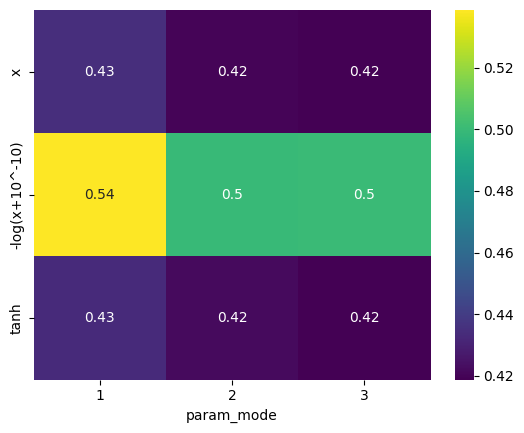

In [107]:

# Get the results in a DataFrame
funcs = ["x", "-log(x+10^-10)", "tanh"]
results = pd.DataFrame(grid.cv_results_)
results.drop_duplicates(subset=['param_func', 'param_mode'], inplace=True)
pivoted_results = results.pivot(index='param_func', columns='param_mode', values='mean_test_score')
pivoted_results = pivoted_results.fillna(0)
# Plot the heatmap
# change the row names to funcs
pivoted_results.index = funcs
sns.heatmap(pivoted_results, annot=True, cmap='viridis')


### Usando dill y picke para guardar nuestra grid_search en un archivo binário

In [92]:

with open("modelname_grid_search.dill", "wb") as f:
    pickle.dump(grid, f)

In [90]:
results = grid.best_estimator_.predict(X_test)
results = pd.DataFrame(results)


## Celda de pruebas con parámetros

In [108]:
results = []
epsilon = 10**-10
for movie in X_test:
    results.append(movie_review_categorizer(movie, lambda x: -log(x+epsilon), mode = 1,max_sum = False, theta = 0.5))

results = pd.DataFrame(results)


## Matriz de confusión y classification report de test

              precision    recall  f1-score   support

         pos       0.59      0.62      0.61       201
         neg       0.60      0.56      0.58       199

    accuracy                           0.59       400
   macro avg       0.59      0.59      0.59       400
weighted avg       0.59      0.59      0.59       400



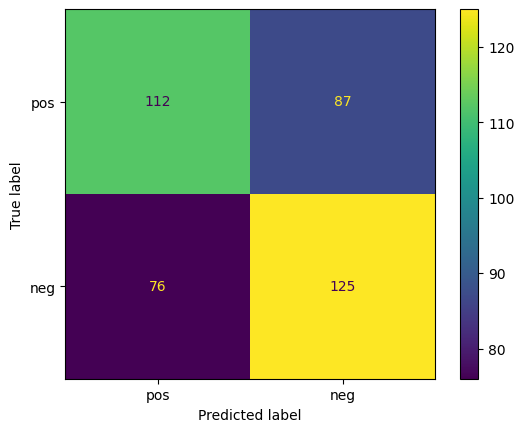

In [109]:


y_train_df = pd.DataFrame(y_test)
print(classification_report(y_train_df, results, target_names=['pos', 'neg']))
conf_matrix = confusion_matrix(y_train_df, results, labels=['pos', 'neg'])  
conf_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=['pos', 'neg'])
conf_matrix.plot()
plt.show()